## One time Aggregation

In [ ]:
import os
import re
import json
import pandas as pd

# Folders
latency_folder    = "./latency"
throughput_folder = "./throughput"

# Filename parser
pattern = re.compile(
    r"results_in(?P<input_len>\d+)_out(?P<output_len>\d+)"
    r"_bs(?P<batch_size>\d+)_tp(?P<tp>\d+)\.json$"
)

def load_metrics(folder, metrics_list):
    """
    Scans `folder` for JSONs matching our pattern,
    loads only the keys in metrics_list, and returns
    a list of dicts with the parsed params + metrics.
    """
    records = []
    for fname in os.listdir(folder):
        m = pattern.match(fname)
        if not m:
            continue
        params = { k: int(v) for k, v in m.groupdict().items() }
        path = os.path.join(folder, fname)
        with open(path) as f:
            data = json.load(f)
        # extract only requested metrics (will be None if missing)
        rec = params.copy()
        for key in metrics_list:
            rec[key] = data.get(key)
        records.append(rec)
    return records

# metrics we care about in each JSON
latency_metrics    = [
    "avg_latency",
    "avg_prefill_latency",
    "avg_decode_latency",
    "avg_decode_per_iter_latency",
]
throughput_metrics = [
    "elapsed_time",
    "num_requests",
    "total_num_tokens",
    "requests_per_second",
    "tokens_per_second",
    "prefill_throughput",
    "decode_throughput",
    "prefill_tokens",
    "decode_tokens",
    "prefill_time",
    "decode_time",
]

# Load both
lat_records = load_metrics(latency_folder, latency_metrics)
thr_records = load_metrics(throughput_folder, throughput_metrics)

# Build DataFrames
df_lat = pd.DataFrame(lat_records)
df_thr = pd.DataFrame(thr_records)

# Merge on the four config columns
df = pd.merge(
    df_lat,
    df_thr,
    on=["input_len", "output_len", "batch_size", "tp"],
    how="outer",  # or 'inner' if you only want pairs present in both
)

# Optional: sort
df = df.sort_values(
    by=["input_len", "batch_size", "tp"]
).reset_index(drop=True)

# Save to CSV
out_csv = "./combined_metrics.csv"
df.to_csv(out_csv, index=False)
print(f"Wrote combined metrics to {out_csv}")


Wrote combined metrics to ./combined_metrics.csv


## Charts

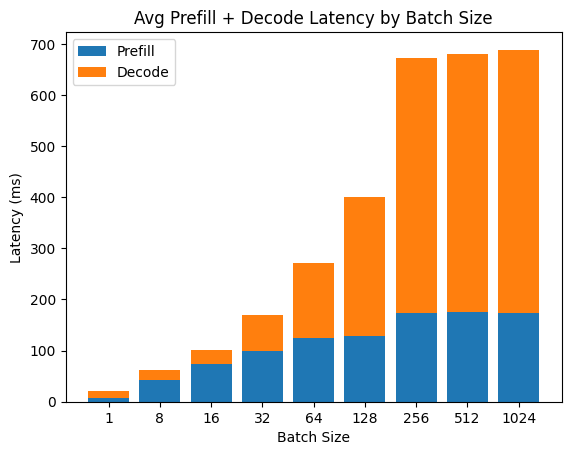

In [ ]:
import os
import re
import json
import pandas as pd
import matplotlib as plt
df = pd.read_csv("./combined_metrics.csv")


In [ ]:
import numpy as np

# Ensure numeric types
df['input_len']   = df['input_len'].astype(int)
df['batch_size']  = df['batch_size'].astype(int)
df['tp']          = df['tp'].astype(int)

# Helper to make a pivot for a given metric and tp
def make_pivot(df, metric, tp):
    sub = df[df['tp'] == tp]
    return sub.pivot_table(
        index='input_len',
        columns='batch_size',
        values=metric,
        aggfunc=np.mean
    )

# Pivot for tp=1
pivot_latency_tp1          = make_pivot(df, 'avg_latency', 1)
pivot_prefill_tp1          = make_pivot(df, 'avg_prefill_latency', 1)
pivot_decode_tp1           = make_pivot(df, 'avg_decode_latency', 1)
pivot_decode_per_itr_tp1   = make_pivot(df, 'avg_decode_per_iter_latency', 1)

# Pivot for tp=8
pivot_latency_tp8          = make_pivot(df, 'avg_latency', 8)
pivot_prefill_tp8          = make_pivot(df, 'avg_prefill_latency', 8)
pivot_decode_tp8           = make_pivot(df, 'avg_decode_latency', 8)
pivot_decode_per_itr_tp8   = make_pivot(df, 'avg_decode_per_iter_latency', 8)


/tmp/ipykernel_235358/1850949786.py:11: FutureWarning: The provided callable <function mean at 0x7f6c28d439c0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  return sub.pivot_table(
/tmp/ipykernel_235358/1850949786.py:11: FutureWarning: The provided callable <function mean at 0x7f6c28d439c0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  return sub.pivot_table(
/tmp/ipykernel_235358/1850949786.py:11: FutureWarning: The provided callable <function mean at 0x7f6c28d439c0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  return sub.pivot_table(
/tmp/ipykernel_235358/1850949786.py:11: FutureWarning: The provi

/tmp/ipykernel_235358/521335594.py:24: FutureWarning: The provided callable <function mean at 0x7f6c28d439c0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  return sub.pivot_table(
/tmp/ipykernel_235358/521335594.py:24: FutureWarning: The provided callable <function mean at 0x7f6c28d439c0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  return sub.pivot_table(
/tmp/ipykernel_235358/521335594.py:24: FutureWarning: The provided callable <function mean at 0x7f6c28d439c0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  return sub.pivot_table(
/tmp/ipykernel_235358/521335594.py:24: FutureWarning: The provided 

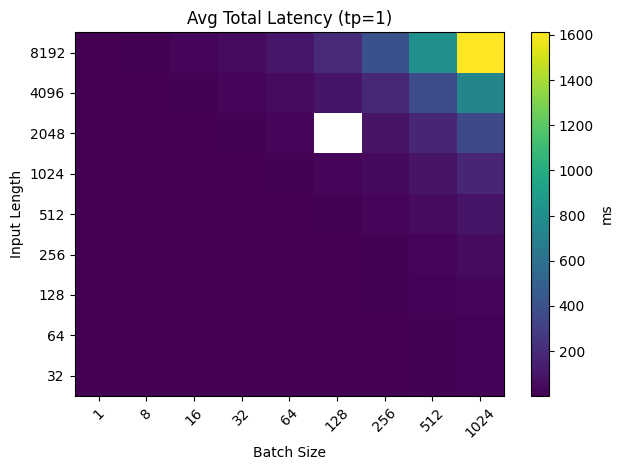

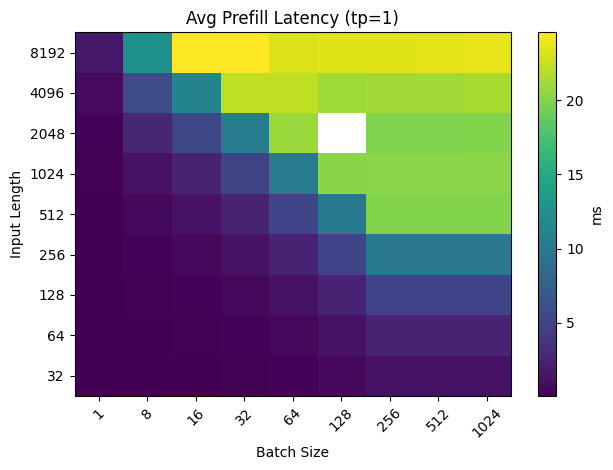

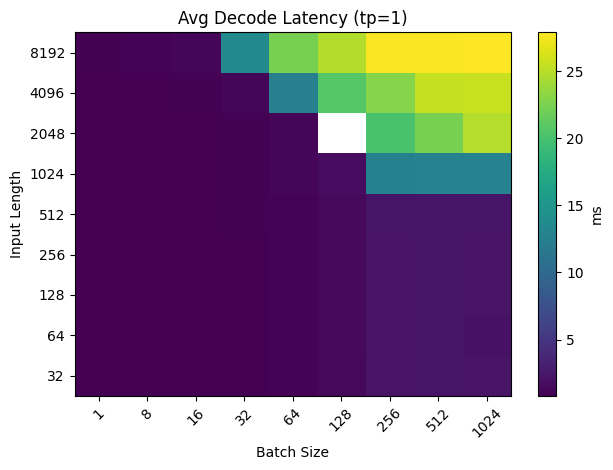

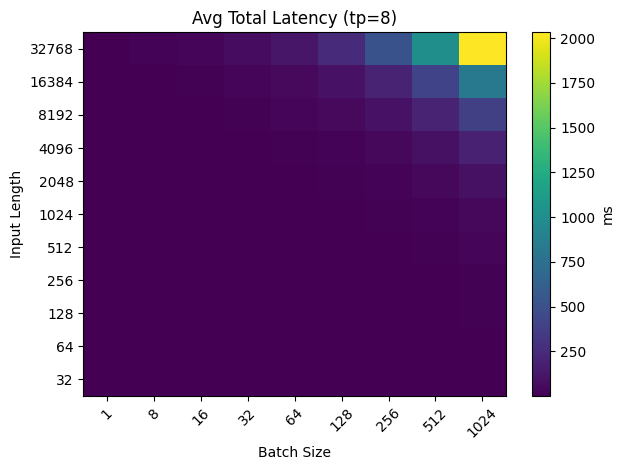

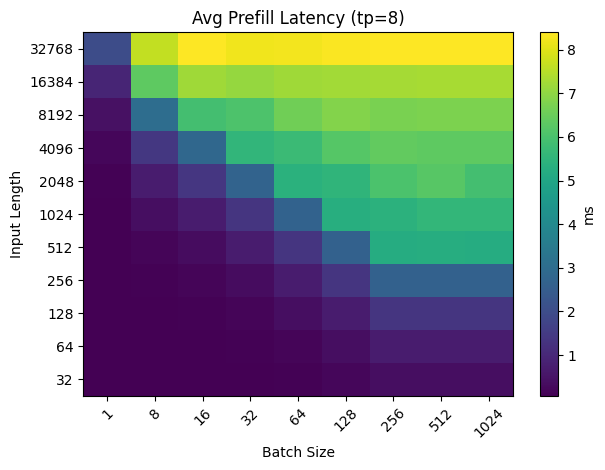

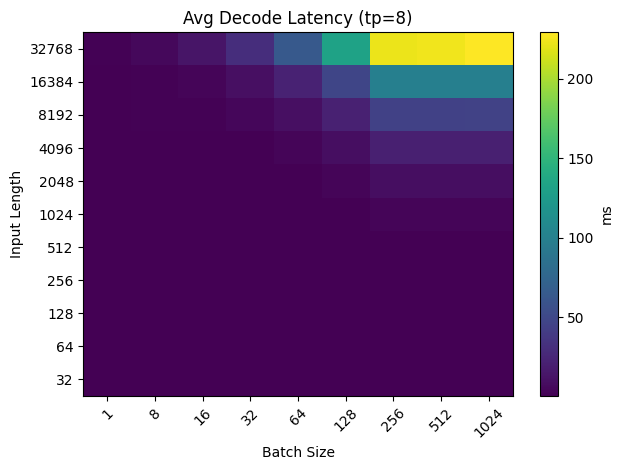

In [ ]:
import matplotlib.pyplot as plt

# Helper function to plot a heatmap
def plot_heatmap(pivot, title, unit ='ms'):
    plt.figure()
    im = plt.imshow(pivot, aspect='auto', origin='lower')
    plt.title(title)
    plt.xlabel('Batch Size')
    plt.ylabel('Input Length')
    plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=45)
    plt.yticks(range(len(pivot.index)), pivot.index)
    plt.colorbar(im, label=unit)
    plt.tight_layout()
    plt.show()

# Pivot creation (ensure this cell runs first):
import numpy as np
df['input_len']   = df['input_len'].astype(int)
df['batch_size']  = df['batch_size'].astype(int)
df['tp']          = df['tp'].astype(int)

def make_pivot(df, metric, tp):
    sub = df[df['tp'] == tp]
    return sub.pivot_table(
        index='input_len',
        columns='batch_size',
        values=metric,
        aggfunc=np.mean
    )

pivot_latency_tp1        = make_pivot(df, 'avg_latency', 1)
pivot_prefill_tp1        = make_pivot(df, 'avg_prefill_latency', 1)
pivot_decode_tp1         = make_pivot(df, 'avg_decode_latency', 1)

pivot_latency_tp8        = make_pivot(df, 'avg_latency', 8)
pivot_prefill_tp8        = make_pivot(df, 'avg_prefill_latency', 8)
pivot_decode_tp8         = make_pivot(df, 'avg_decode_latency', 8)

# Then run the plotting code:
plot_heatmap(pivot_latency_tp1, 'Avg Total Latency (tp=1)')
plot_heatmap(pivot_prefill_tp1, 'Avg Prefill Latency (tp=1)')
plot_heatmap(pivot_decode_tp1, 'Avg Decode Latency (tp=1)')
plot_heatmap(pivot_latency_tp8, 'Avg Total Latency (tp=8)')
plot_heatmap(pivot_prefill_tp8, 'Avg Prefill Latency (tp=8)')
plot_heatmap(pivot_decode_tp8, 'Avg Decode Latency (tp=8)')


/tmp/ipykernel_235358/521335594.py:24: FutureWarning: The provided callable <function mean at 0x7f6c28d439c0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  return sub.pivot_table(
/tmp/ipykernel_235358/521335594.py:24: FutureWarning: The provided callable <function mean at 0x7f6c28d439c0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  return sub.pivot_table(
/tmp/ipykernel_235358/521335594.py:24: FutureWarning: The provided callable <function mean at 0x7f6c28d439c0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  return sub.pivot_table(
/tmp/ipykernel_235358/521335594.py:24: FutureWarning: The provided 

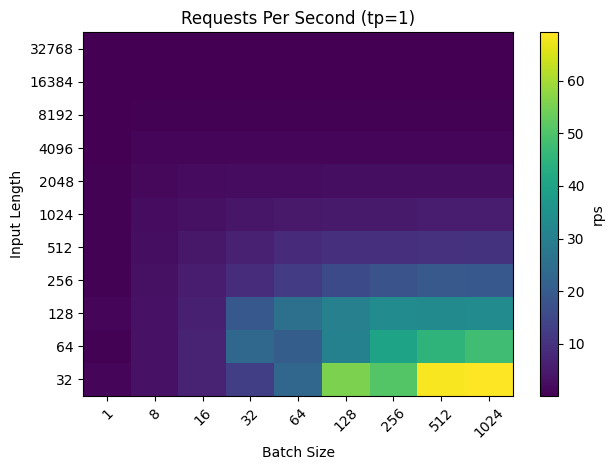

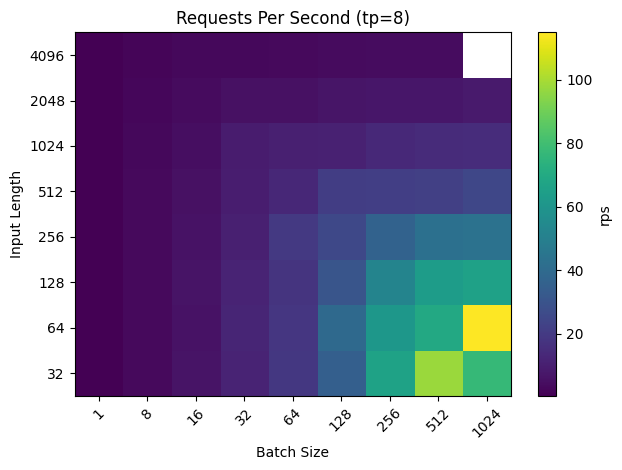

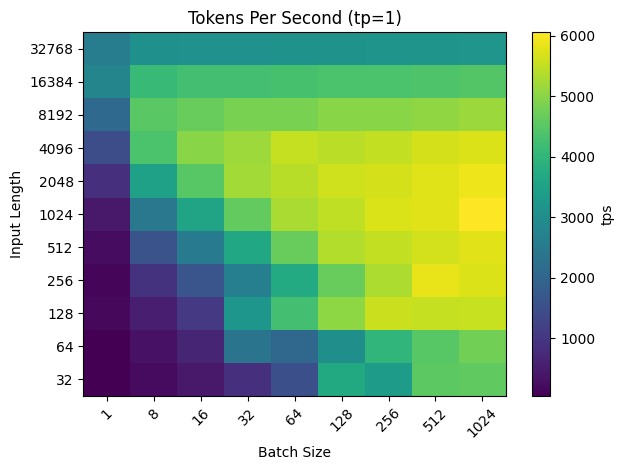

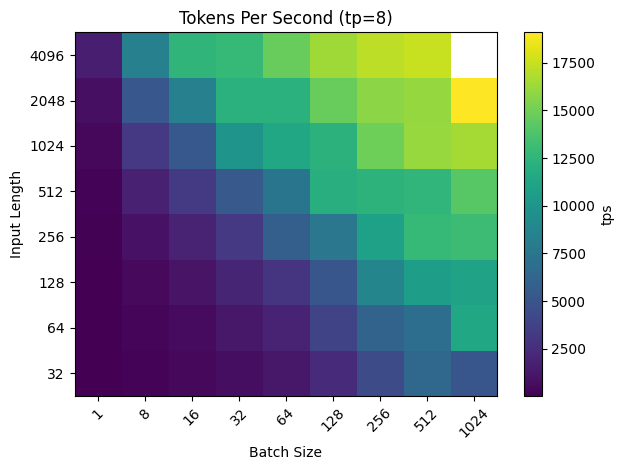

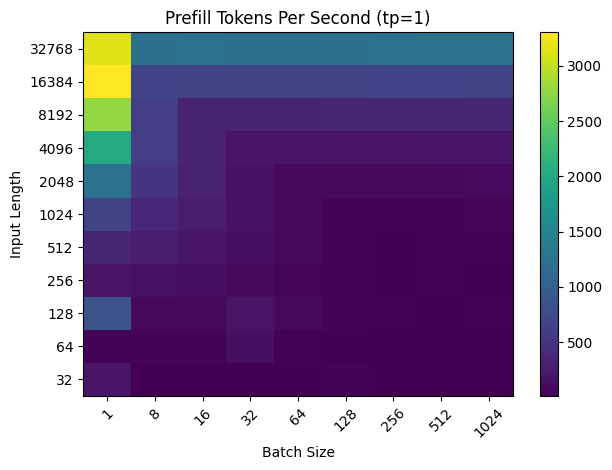

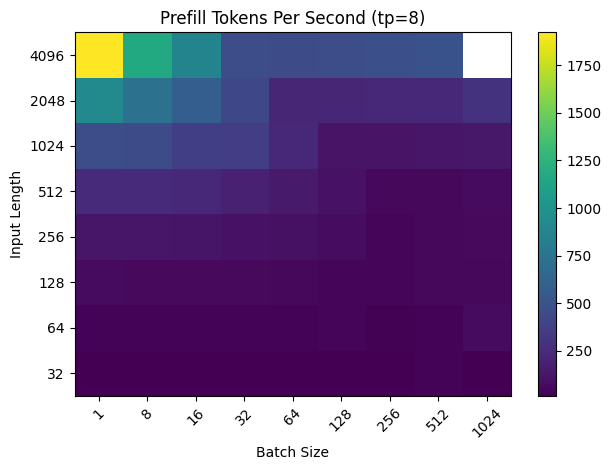

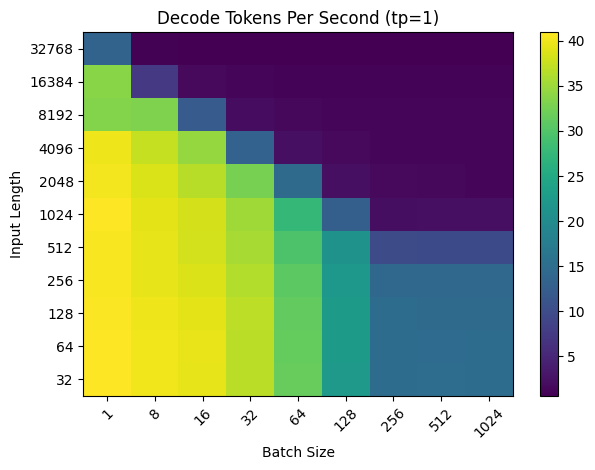

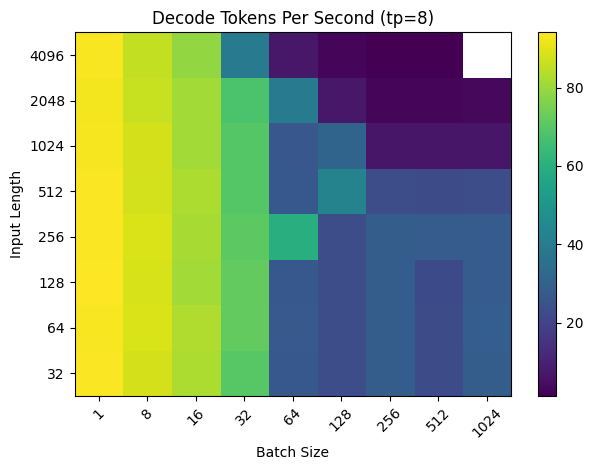

In [ ]:
pivot_rps_tp1     = make_pivot(df, 'requests_per_second', tp=1)
pivot_tps_tp1     = make_pivot(df, 'tokens_per_second',   tp=1)
pivot_rps_tp8     = make_pivot(df, 'requests_per_second', tp=8)
pivot_tps_tp8     = make_pivot(df, 'tokens_per_second',   tp=8)
pivot_pref_tp1     = make_pivot(df, 'prefill_throughput', tp=1)
pivot_dec_tp1     = make_pivot(df, 'decode_throughput',   tp=1)
pivot_pref_tp8     = make_pivot(df, 'prefill_throughput', tp=8)
pivot_dec_tp8     = make_pivot(df, 'decode_throughput',   tp=8)

plot_heatmap(pivot_rps_tp1, 'Requests Per Second (tp=1)', 'rps')
plot_heatmap(pivot_rps_tp8, 'Requests Per Second (tp=8)', 'rps')
plot_heatmap(pivot_tps_tp1, 'Tokens Per Second (tp=1)', 'tps')
plot_heatmap(pivot_tps_tp8, 'Tokens Per Second (tp=8)', 'tps')
plot_heatmap(pivot_pref_tp1, 'Prefill Tokens Per Second (tp=1)', '')
plot_heatmap(pivot_pref_tp8, 'Prefill Tokens Per Second (tp=8)', '')
plot_heatmap(pivot_dec_tp1, 'Decode Tokens Per Second (tp=1)', '')
plot_heatmap(pivot_dec_tp8, 'Decode Tokens Per Second (tp=8)', '')
